In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from sklearn.preprocessing import StandardScaler
from collections import Counter
import random
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm

In [2]:
datas_folder = "clean_datas/"
train_data_file = "ecfp_train.csv"
test_data_file = "ecfp_test.csv"
cddd_train_file = "cddd_train.csv"
cddd_test_file =  "cddd_test.csv"
mix_train_file = "mix_train.csv"
mix_test_file =  "mix_test.csv"
train = pd.read_csv(datas_folder + train_data_file)
test = pd.read_csv(datas_folder + test_data_file)
cddd_train = pd.read_csv(datas_folder + cddd_train_file)
cddd_test = pd.read_csv(datas_folder + cddd_test_file)
mix_train = pd.read_csv(datas_folder + mix_train_file)
mix_test = pd.read_csv(datas_folder + mix_test_file)


In [3]:
def custom_loss(y_true, y_pred):
    y_pred_exp = np.exp(y_pred)
    loss = mean_squared_error(np.exp(y_true), y_pred_exp) 
    return loss
custom_scorer = make_scorer(custom_loss, greater_is_better=False)

def prep_fitt(datas):
    datas = datas.copy()
    try:
        return datas.drop(labels=["RT", "SMILES", "mol", "Compound"], axis=1)
    except Exception:
        return datas.drop(labels=["SMILES", "mol", "Compound"], axis=1)
    
    
# CDDD_datas
#y = cddd_train["RT"]
#X = prep_fitt(cddd_train)
#X_test = prep_fitt(cddd_test)


# ECFP_datas
#y = train["RT"]
#X = prep_fitt(train)
#X_test = prep_fitt(test)


# MIXED_datas
#scaler = StandardScaler()
y = mix_train["RT"]
X = prep_fitt(mix_train)
#X= pd.DataFrame(scaler.fit_transform(X))
X_test = prep_fitt(mix_test)
#X_test = pd.DataFrame(scaler.transform(X_test))

In [4]:

seed_num = 31
torch.use_deterministic_algorithms(True)
random.seed(seed_num)
np.random.seed(seed_num)
torch.manual_seed(seed_num)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(seed_num)
print(" ")


# FNN MoDel 3 Hidden-Layers 


In [5]:

class DNNModel(nn.Module):
    def __init__(self, input_size, n1, n2,n3, activation, dropout_rate = None):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, n1)
        self.activation1 = nn.ReLU() if activation == 'relu' else nn.Tanh() if activation == 'tanh' else nn.Softmax(dim=1)
        self.fc2 = nn.Linear(n1, n2)
        self.activation2 = nn.ReLU() if activation == 'relu' else nn.Tanh() if activation == 'tanh' else nn.Softmax(dim=1)
        self.fc3 = nn.Linear(n2, n3)
        self.activation3 = nn.ReLU() if activation == 'relu' else nn.Tanh() if activation == 'tanh' else nn.Softmax(dim=1)
        self.fc4 = nn.Linear(n3,1)
        if type(dropout_rate) == float : 
            self.dropout = nn.Dropout(dropout_rate)
            self.drop_or_no_drop = True
        else : 
            self.drop_or_no_drop = False
    

    def forward(self, x): 
        if self.drop_or_no_drop == True :
            x = self.activation1(self.fc1(x))
            x = self.dropout(x)
            x = self.activation2(self.fc2(x))
            x = self.dropout(x)
            x = self.activation3(self.fc3(x))
            x = self.dropout(x)
            x = self.fc4(x)
            return x
        if self.drop_or_no_drop == False : 
            x = self.activation1(self.fc1(x))
            x = self.activation2(self.fc2(x))
            x = self.activation3(self.fc3(x))
            x = self.fc4(x)
            return x


### Train / Test function

In [6]:
def train(model, train_loader, optimizer, criterion, scheduler = None): 
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if scheduler != None :
            scheduler.step()
    return train_loss / len(train_loader)

def test(model, test_loader, criterion) : 
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        inputs, labels = test_loader[:]
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss = loss.item()
    return [test_loss, np.sqrt(test_loss)]

### Simple Validation with monitoring

Trainig Epochs: 100%|██████████| 150/150 [05:00<00:00,  2.00s/epoch]


Final  test error : 0.522785484790802 | Final train error : 0.26483476161956787 | Min test error : 0.5212
Epoch for minimum test loss : 144


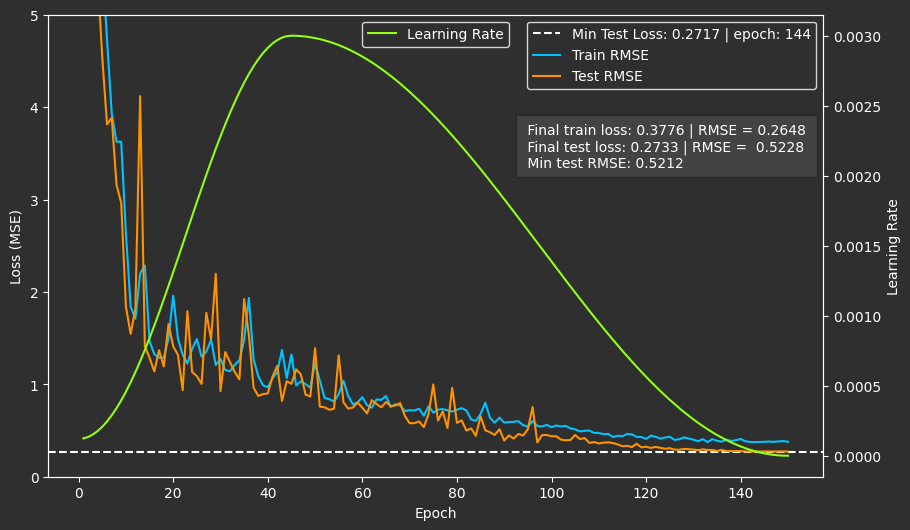

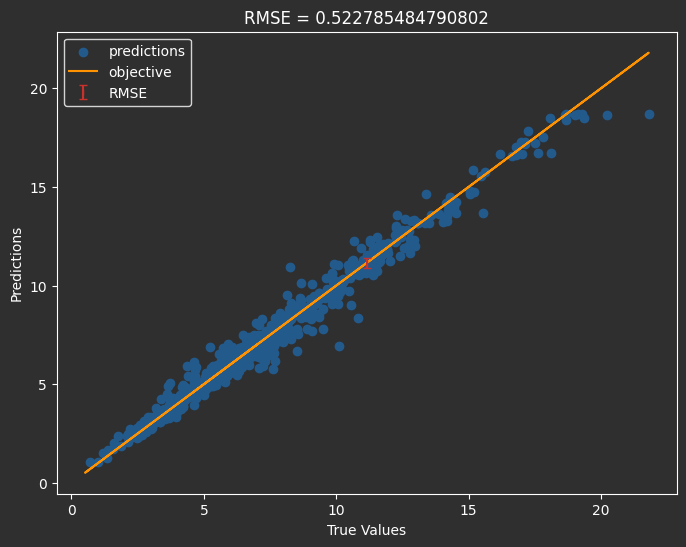

0

In [8]:
def simple_validation(X, y, params, learning_rate = 0.001, test_size = 0.5, lr_modifier = False, batch_normal = False, verbose = False, nested_cross_validation = False, y_val = None, X_val = None) : 
    n1, n2, n3,activation = params["n1"], params["n2"],params["n3"] ,params["activation"]
    try : 
        num_epochs =  params["num_epochs"]
    except : 
        num_epochs=450
    try : 
        batch_size = params["batch_size"]
    except: 
        batch_size= None
    try : 
        dropout_rate = params["dropout_rate"]
    except : 
        dropout_rate = None
    try : 
        lr_max = params["lr_max"]
    except : 
        lr_max = 0.003
    try : 
        opti = params["opti"]
        #print(activation)
    except : 
        opti = "adam"
        
    
    if not nested_cross_validation : 
        X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32).view(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle = True)  
    else : 
        y_test = y_val
        X_test = X_val
        X_train = X
        y_train = y
        
    train_loader = TensorDataset(X_train, y_train)
    test_loader = TensorDataset(X_test,y_test)
    
    if batch_size == None : 
        #print("Attention no batch \n")
        train_loader = DataLoader(train_loader, batch_size=len(X_train), shuffle=True, worker_init_fn= seed_worker, generator=g)
    else : 
        #print(f"- batch size: {batch_size}\n")
        train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True, worker_init_fn= seed_worker, generator=g)
    
        
    model = DNNModel(input_size= X_train.shape[1],  n1=n1,  n2=n2, n3 = n3,activation=activation, dropout_rate=dropout_rate)
    criterion = nn.MSELoss()
    
    if opti == "adam" : 
        optimizer = optim.Adam(model.parameters(), lr= learning_rate) 
    
    else : 
        optimizer = AdamW(model.parameters(), lr=0.001, weight_decay= 0.01)
    
    
    if lr_modifier :
        scheduler = OneCycleLR(optimizer, max_lr= lr_max, total_steps=num_epochs * len(train_loader))

    prev_lr = None
    train_losses = []
    test_losses = []
    rmse_loss = []
    epochs_list = list(range(1, num_epochs + 1))
    lr_list = []
    
    

    for epoch in tqdm(range(num_epochs),disable = verbose,desc = "Trainig Epochs",unit ="epoch" ,colour = "green") : 
    
        if lr_modifier :                
            train_loss = train(model, train_loader, criterion= criterion, optimizer=optimizer, scheduler= scheduler)
        else : 
            train_loss = train(model, train_loader, criterion= criterion, optimizer=optimizer)
        
        train_losses.append(train_loss)
        
        test_loss = test(model, test_loader, criterion=criterion)
        test_losses.append(test_loss[0])
        rmse_loss.append(test_loss[1])
        
        if lr_modifier :
            current_lr = scheduler.optimizer.param_groups[0]['lr']
            lr_list.append(current_lr)
            
            if current_lr != prev_lr:  
                prev_lr = current_lr
            if verbose and not nested_cross_validation: 
                print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss[0]:.4f}, Learning Rate: {current_lr} ')
        else : 
            if verbose and not nested_cross_validation :
                print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss[0]:.4f}")
        
    model.eval()   
    with torch.no_grad():
            prediction = model(X_test)
            training = model(X_train)
        
    rmse_test = np.sqrt(mean_squared_error(y_test, prediction))
    rmse_train = np.sqrt(mean_squared_error(y_train,training))
    if nested_cross_validation : 
        return [rmse_train, rmse_test] 
    
    else:
        print(f"Final  test error : {rmse_test} | Final train error : {rmse_train} | Min test error : {np.min(rmse_loss):.4f}")  
        fig, ax = plt.subplots(figsize=(10, 6))
        i = test_losses.index(min(test_losses))
        print(f"Epoch for minimum test loss : {epochs_list[i]}")
        min_test_loss_value = test_losses[i]
        min_test_loss_epoch = epochs_list[i]
        ax.axhline(min_test_loss_value, linestyle='--', color='white', label=f'Min Test Loss: {min_test_loss_value:.4f} | epoch: {min_test_loss_epoch}')
        ax.plot(epochs_list, train_losses, label='Train RMSE', c='#00C3FF')
        ax.plot(epochs_list,test_losses, color="#FF9200", label='Test RMSE')
        
        if lr_modifier : 
            ax2 = ax.twinx()
            ax2.set_ylabel('Learning Rate', color="white")
            ax2.plot(epochs_list, lr_list, color="#90FF15", label="Learning Rate")
            ax2.tick_params(axis='y', colors="white")
            ax2.legend(loc='upper center', facecolor='#2F2F2F', edgecolor='white', labelcolor='white')
            ax2.spines['bottom'].set_color('white')  
            ax2.spines['top'].set_color('white')    
            ax2.spines['right'].set_color('white')   
            ax2.spines['left'].set_color('white')    
            ax2.xaxis.label.set_color('white')
            ax2.yaxis.label.set_color('white')
            
        #ax.grid(color='#E27429', linestyle='--', linewidth=0.5)
        ax.set_facecolor('#2F2F2F') 
        ax.spines['bottom'].set_color('white')  
        ax.spines['top'].set_color('white')    
        ax.spines['right'].set_color('white')   
        ax.spines['left'].set_color('white')    
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        fig.patch.set_facecolor('#2F2F2F')
        ax.legend(loc='upper right', facecolor='#2F2F2F', edgecolor='white', labelcolor='white')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss (MSE)')
        #ax.set_ylim(0, 2.5)
        #ax.set_ylim(0, np.max(test_losses))
        ax.set_ylim(0,5)
        
        plt.figtext(0.6, 0.63,  
                f" Final train loss: {train_losses[-1]:.4f} | RMSE = {rmse_train:.4f} \n Final test loss: {test_losses[-1]:.4f} | RMSE =  {(rmse_test):.4f} \n Min test RMSE: {np.min(rmse_loss):.4f}", 
                horizontalalignment ="left", 
                wrap = True, fontsize = 10,  
                bbox ={'facecolor':'grey',  
                    'alpha':0.25, 'pad':5},
                color = "white")
                
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(y_test, prediction, c="#235a8c", label='predictions')
        ax.plot(y, y, color="#FF9200", label='objective')
        #ax.grid(color='white', linestyle='--', linewidth=0.5)
        ax.errorbar(x=(min(y) + max(y)) / 2, y=(min(y) + max(y)) / 2,
                yerr=rmse_test/2, color='#c9312c', fmt='|', markersize=5, capsize=3, label='RMSE')
        
        
        ax.set_facecolor('#2F2F2F') 
        ax.spines['bottom'].set_color('white')  
        ax.spines['top'].set_color('white')    
        ax.spines['right'].set_color('white')   
        ax.spines['left'].set_color('white')    
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        fig.patch.set_facecolor('#2F2F2F')
        ax.legend(loc='upper left', facecolor='#2F2F2F', edgecolor='white', labelcolor='white')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.set_title(f'RMSE = {rmse_test}', color='white')
        plt.show()
        
    
        return 0
    
param = {'n1': 1024, 'n2': 2048,"n3" : 512,'activation': 'tanh', "num_epochs" :150, "batch_size" : 64, "dropout_rate" : 0.3, "opti" : "adamW", "lr_max" : 0.003}  #mix 200 0.003 c'est ouf !!!
simple_validation(X,y,param, test_size= 0.2, learning_rate = 0.001, lr_modifier= True, batch_normal= False, verbose=False,)  # Adam ou AdamW !!!


# LE LR MODIFIER NOUS PERME DE PRESQUE GARDER LES MEMES PERFORMANCES EN UTILISANT ADAMW ET DROPOUT ALORS QUE SANS DIMINUE FRANCHEMENT

### Sumbmission function 


In [ ]:

def submission(X,y,X_test,params,file_name,scheduler = False, learning_rate = 0.001) : 
    
    n1, n2, n3,activation = params["n1"], params["n2"], params["n3"],params["activation"]
    try : 
        num_epochs = params["num_epochs"]
    except : 
        num_epochs=300
    try : 
        batch_size = params["batch_size"]
    except: 
        batch_size= None
    try : 
        dropout_rate = params["dropout_rate"]
        #print(f"CAA DROP OUT FOOOOORRRTTTT {dropout_rate}")
    except : 
        dropout_rate = None
    
    X = torch.tensor(X.to_numpy(), dtype=torch.float32)
    y = torch.tensor(y.to_numpy(), dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
   
    train_loader = TensorDataset(X, y)
    train_loader = DataLoader(train_loader, batch_size= batch_size, shuffle=True, worker_init_fn= seed_worker, generator=g)
     
    model = DNNModel(X.shape[1], n1, n2, n3,activation, dropout_rate= dropout_rate)
    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay= 0.01)
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    if scheduler :
        scheduler = OneCycleLR(optimizer, max_lr=0.003, total_steps= num_epochs * len(train_loader))
    
    else :
        scheduler = None
        
    for epoch in tqdm(range(num_epochs), desc= "Training Epochs", unit = "epoch", colour = "green") : 
        train(model=model , train_loader=train_loader , optimizer=optimizer , criterion=criterion , scheduler=scheduler)


    model.eval()
    with torch.no_grad():
        prediction = model(X_test)
        
    sub_dataframe = pd.DataFrame(list(enumerate(prediction.numpy(), start=1)), columns=['ID', 'RT']).astype(float)
    submission_name = f'prediction/{file_name}.csv'     
    sub_dataframe.to_csv(submission_name, index=False)
    torch.save(model.state_dict(), f'model/{file_name}.pth')
    print("_________________\n| Prediction Saved :D ")
    

param = {'n1': 1024, 'n2': 2048, "n3" : 512, 'activation': 'tanh', "num_epochs" :300, "batch_size" : 64} 
#submission(X=X , y=y , X_test=X_test , params=param , file_name="MIX_03_LRcycle_",scheduler= True,)
